In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='html5')
plt.style.use('seaborn-v0_8-whitegrid')

# NUM_EXAMPLES = 256
# BATCH_SIZE = 8
# STEPS = 50 # actually steps
# LR = 0.1


def animate_sgd(num_examples, batch_size, steps, learning_rate,
                true_w=3.0, true_b=2.0, seed=0):
    # Define model
    class Model(object):
        def __init__(self, w_init=-1.0, b_init=-1.0):
            self.W = tf.Variable(w_init)
            self.b = tf.Variable(b_init)

        def __call__(self, x):
            return self.W * x + self.b
            
    def loss(target_y, predicted_y):
        return tf.reduce_mean(tf.square(target_y - predicted_y))

    def train(model, inputs, outputs, learning_rate):
        with tf.GradientTape() as t:
            current_loss = loss(outputs, model(inputs))
            dW, db = t.gradient(current_loss, [model.W, model.b])
            model.W.assign_sub(learning_rate * dW)
            model.b.assign_sub(learning_rate * db)
    # Data
    inputs  = tf.random.normal(shape=[num_examples], seed=seed)
    noise   = tf.random.normal(shape=[num_examples], seed=seed+1)
    outputs = inputs * true_w + true_b + noise
    ds = (tf.data.Dataset
          .from_tensor_slices((inputs, outputs))
          .shuffle(1000, seed=seed)
          .batch(batch_size)
          .repeat())
    ds = iter(ds)
    model = Model()
    # Collect the history of W-values and b-values to plot later
    Ws, bs, xs, ys, ls = [], [], [], [], []
    # Construct plot
    fig = plt.figure(dpi=100, figsize=(8, 3))

    # Regression Line
    ax1 = fig.add_subplot(131)
    ax1.set_title("Fitted Line")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_xlim(-3, 2.5)
    ax1.set_ylim(-8, 11)
    p10, = ax1.plot(inputs, outputs, 'r.', alpha=0.1) # full dataset
    p11, = ax1.plot([], [], 'C3.') # batch, color Red
    p12, = ax1.plot([], [], 'k') # fitted line, color Black

    # Loss
    ax2 = fig.add_subplot(132)
    ax2.set_title("Training Loss")
    ax2.set_xlabel("Batches Seen")
    ax2.set_xlim(0, steps)
    ax2.set_ylim(0, 40)
    p20, = ax2.plot([], [], 'C0') # color Blue

    # Weights
    ax3 = fig.add_subplot(133)
    ax3.set_title("Weights")
    ax3.set_xlabel("Batches Seen")
    ax3.set_xlim(0, steps)     # 
    ax3.set_ylim(-2, 4)
    ax3.plot(range(steps), [true_w for _ in range(steps)], 'C5--')
    ax3.plot(range(steps), [true_b for _ in range(steps)], 'C8--')
    p30, = ax3.plot([], [], 'C5') # W color Brown
    p30.set_label('W')
    p31, = ax3.plot([], [], 'C8') # b color Green
    p31.set_label('b')
    ax3.legend()

    fig.tight_layout()

    def init():
        return [p10]

    def update(epoch):
        x, y = next(ds)
        y_pred = model(x)
        current_loss = loss(y, y_pred)
          
        Ws.append(model.W.numpy())
        bs.append(model.b.numpy())
        xs.append(x.numpy())
        ys.append(y_pred.numpy())
        ls.append(current_loss.numpy())
        p11.set_data(x.numpy(), y.numpy())
        inputs = tf.linspace(-3.0, 2.5, 30)
        p12.set_data(inputs, Ws[-1]*inputs + bs[-1])
        p20.set_data(range(epoch), ls)
        p30.set_data(range(epoch), Ws)
        p31.set_data(range(epoch), bs)

        train(model, x, y, learning_rate=learning_rate)
        #   print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        #         (epoch, Ws[-1], bs[-1], current_loss))
        
        return p11, p12, p20

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(1, steps),
        init_func=init,
        blit=True,
        interval=100,
    )
    plt.close()
    return ani

# Uvod #

U ovoj ćete vježbi uvježbati neuronsku mrežu na skupu podataka *Fuel Economy*, a zatim istražiti učinak stope učenja i veličine serije na SGD.

Kada budete spremni, pokrenite ovu sljedeću ćeliju da sve postavite!

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
#from learntools.deep_learning_intro.dltools import animate_sgd
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



U skupu podataka *Fuel Economy* vaš je zadatak predvidjeti potrošnju goriva automobila s obzirom na značajke poput vrste motora ili godine proizvodnje.

Prvo učitajte skup podataka pokretanjem donje ćelije.

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

fuel = pd.read_csv('./input/fuel.csv')

X = fuel.copy()
# Remove target
y = X.pop('FE')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [50]


Ako želite, pogledajte podatke. Naš cilj u ovom slučaju je stupac `'FE'`, a preostali stupci su značajke.

In [4]:
# Uncomment to see original data
fuel.head()
# Uncomment to see processed features
pd.DataFrame(X[:10,:]).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.296693,2.120794,0.524148,-1.458464,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pokrenite sljedeću ćeliju da definirate mrežu koju ćemo koristiti za ovaj zadatak.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

# 1) Dodajte gubitak - loss i optimizator

Prije treniranja mreže moramo definirati gubitak i optimizator koji ćemo koristiti. Koristeći metodu `compile` modela, dodajte `Adam` optimizator i `MAE` gubitak.

In [6]:
# YOUR CODE HERE
model.compile(
    optimizer="adam",
    loss="mae",
)

# 2) Treniranje Modela

Nakon što definirate model i kompajlirate ga s gubitkom i optimizatorom, spremni ste za traniranje. Uvježbajte mrežu za 200 epoha s veličinom serije od 128. Ulazni podaci su "X" s ciljem "y".

In [8]:
# YOUR CODE HERE
history = model.fit(
    X, y,
    batch_size=128,
    epochs=200,
)

Epoch 1/200

9/9 [==============================] - 1s 2ms/step - loss: 2.7392
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 0.9517
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 0.5507
Epoch 4/200
9/9 [==============================] - 0s 1ms/step - loss: 0.3300
Epoch 5/200
9/9 [==============================] - 0s 1ms/step - loss: 0.2294
Epoch 6/200
9/9 [==============================] - 0s 1ms/step - loss: 0.1659
Epoch 7/200
9/9 [==============================] - 0s 1ms/step - loss: 0.1310
Epoch 8/200
9/9 [==============================] - 0s 1ms/step - loss: 0.1099
Epoch 9/200
9/9 [==============================] - 0s 1ms/step - loss: 0.0944
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0868
Epoch 11/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0803
Epoch 12/200
9/9 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 13/200
9/9 [==============================] - 0s 1ms/s

Zadnji korak je pogledati krivulje gubitaka i procijeniti trening. Pokrenite donju ćeliju da dobijete dijagram gubitka treninga.

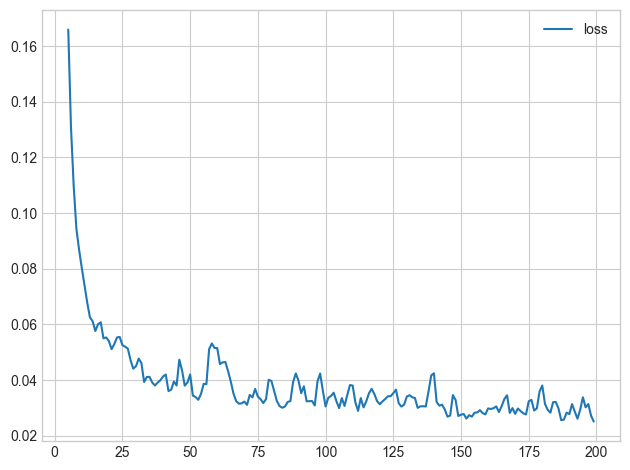

In [9]:
import pandas as pd

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

# 3) Evaluirajte treniranje

Da ste duže trenirali model, biste li očekivali da će se gubitak dodatno smanjiti?

Sa stopom učenja i veličinom serije, imate određenu kontrolu nad tim:
- Koliko dugo traje traniranje modela
- Koliko krivulje učenja imaju šuma
- Kako mali gubitak postaje

Kako bismo bolje razumjeli ova dva parametra, pogledat ćemo linearni model, našu najjednostavniju neuronsku mrežu. Imajući samo jednu težinu i pristranost, lakše je vidjeti kakav učinak ima promjena parametra.

Sljedeća će ćelija generirati animaciju poput one u prethodnoj bilježnici. Promijenite vrijednosti za "learning_rate", "batch_size" i "num_examples" (koliko podatkovnih točaka), a zatim pokrenite ćeliju. (Može potrajati trenutak ili dva.) Isprobajte sljedeće kombinacije ili isprobajte neke svoje:

| `learning_rate` | `batch_size` | `num_examples` |
|-----------------|--------------|----------------|
| 0.05            | 32           | 256            |
| 0.05            | 2            | 256            |
| 0.05            | 128          | 256            |
| 0.02            | 32           | 256            |
| 0.2             | 32           | 256            |
| 1.0             | 32           | 256            |
| 0.9             | 4096         | 8192           |
| 0.99            | 4096         | 8192           |

In [11]:
# YOUR CODE HERE: Experiment with different values for the learning rate, batch size, and number of examples
learning_rate = 0.1
batch_size = 15
num_examples = 256

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these, if you like
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)

RuntimeError: Requested MovieWriter (ffmpeg) not available

# 4) Stopa učenja i veličina serije

Šro mislite, kakav je učinak imala promjena ovih parametara?

# Nastavi #

Naučite kako [**poboljšati preformanse modela**](Overfitting_and_Underfitting_hr.ipynb) podešavanjem kapaciteta ili dodavanjem povratnog poziva za rano zaustavljanje.